# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

## For reproducibility

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Configuration

In [4]:
INPUT_CSV_PATH = "preprocessed_brewery_data_balanced.csv"

In [5]:
FEATURE_COLUMNS = ['Gravity', 'Alcohol_Content', 'pH_Level', 'Moisture_Content', 'Temperature']
TARGET_COLUMN = 'Fermentation_Status'

EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
L2_REG = 0.001
DROPOUT_RATE = 0.3
LSTM_UNITS = 64
DENSE_UNITS_MLP = [128, 64, 32]
DENSE_UNITS_LSTM_POST = [64, 32]

## Load Preprocessed and Balanced Data

In [6]:
print(f"--- Loading Preprocessed and Balanced Data from: {INPUT_CSV_PATH} ---")
try:
    df = pd.read_csv(INPUT_CSV_PATH) # Load all rows
    print(f"Successfully loaded {len(df)} rows from '{INPUT_CSV_PATH}'.")

    if TARGET_COLUMN not in df.columns:
        raise ValueError(f"Target column '{TARGET_COLUMN}' not found in the loaded CSV.")
    missing_features = [col for col in FEATURE_COLUMNS if col not in df.columns]
    if missing_features:
        raise ValueError(f"Missing feature columns in loaded CSV: {missing_features}")

    print("\nDistribution of target variable in loaded data:")
    print(df[TARGET_COLUMN].value_counts(normalize=True))
    print(df[TARGET_COLUMN].value_counts())
    if df[TARGET_COLUMN].nunique() < 2:
        print("CRITICAL ERROR: Loaded data does not contain two classes for the target variable.")
        raise SystemExit("Halting due to data issue: Target variable not diverse in input file.")
    if df.isnull().sum().sum() > 0:
        print("Warning: NaNs found in loaded preprocessed data. Dropping them.")
        df.dropna(inplace=True)
        print(f"Shape after dropping NaNs: {df.shape}")


except FileNotFoundError:
    print(f"ERROR: File '{INPUT_CSV_PATH}' not found. Please run Data_Preprocessing_Balanced.ipynb first.")
    raise
except ValueError as ve:
    print(f"ValueError during data loading: {ve}")
    raise

--- Loading Preprocessed and Balanced Data from: preprocessed_brewery_data_balanced.csv ---
Successfully loaded 3752 rows from 'preprocessed_brewery_data_balanced.csv'.

Distribution of target variable in loaded data:
Fermentation_Status
1    0.5
0    0.5
Name: proportion, dtype: float64
Fermentation_Status
1    1876
0    1876
Name: count, dtype: int64


## Prepare Features (X) and Target (y)

In [7]:
X = df[FEATURE_COLUMNS]
y = df[TARGET_COLUMN]

print(f"\nShape of X: {X.shape}, Shape of y: {y.shape}")


Shape of X: (3752, 5), Shape of y: (3752,)


## Data Splitting

In [8]:
print("\n--- Splitting Data into Train, Validation, and Test sets ---")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Training set: X_train shape {X_train.shape}, y_train shape {y_train.shape}")
print(f"Validation set: X_val shape {X_val.shape}, y_val shape {y_val.shape}")
print(f"Test set: X_test shape {X_test.shape}, y_test shape {y_test.shape}")

print("\nDistributions after splitting:")
print("y_train distribution:", np.unique(y_train, return_counts=True))
print("y_val distribution:", np.unique(y_val, return_counts=True))
print("y_test distribution:", np.unique(y_test, return_counts=True))

if len(np.unique(y_test)) < 2:
    print("CRITICAL ERROR: y_test has only one class after splitting! Check data size and stratification.")
    raise SystemExit("Halting due to y_test having only one class.")


--- Splitting Data into Train, Validation, and Test sets ---
Training set: X_train shape (2250, 5), y_train shape (2250,)
Validation set: X_val shape (751, 5), y_val shape (751,)
Test set: X_test shape (751, 5), y_test shape (751,)

Distributions after splitting:
y_train distribution: (array([0, 1], dtype=int64), array([1125, 1125], dtype=int64))
y_val distribution: (array([0, 1], dtype=int64), array([375, 376], dtype=int64))
y_test distribution: (array([0, 1], dtype=int64), array([376, 375], dtype=int64))


## Feature Scaling

In [9]:
print("\n--- Scaling Features ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print("Feature scaling complete.")


--- Scaling Features ---
Feature scaling complete.


## Model Definitions (same as before)

In [10]:
def create_mlp_model(input_shape, dense_units, dropout_rate, l2_reg_factor):
    model = Sequential(name="MLP_Model")
    model.add(Input(shape=input_shape))
    for units in dense_units:
        model.add(Dense(units, activation='relu', kernel_regularizer=l2(l2_reg_factor)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc', from_logits=False)])
    return model

def create_lstm_model(input_shape_rnn, lstm_units_val, dense_units_post_val, dropout_rate_val, l2_reg_factor):
    model = Sequential(name="LSTM_Model")
    model.add(Input(shape=input_shape_rnn))
    model.add(LSTM(lstm_units_val, kernel_regularizer=l2(l2_reg_factor)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate_val))
    for units in dense_units_post_val:
        model.add(Dense(units, activation='relu', kernel_regularizer=l2(l2_reg_factor)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate_val))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc', from_logits=False)])
    return model

## Training Procedure

In [11]:
print("\n--- Setting up Callbacks ---")
early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=15, restore_best_weights=True, verbose=1)
model_checkpoint_mlp = ModelCheckpoint('best_mlp_model.weights.h5', save_best_only=True, monitor='val_auc', mode='max', save_weights_only=True)
model_checkpoint_lstm = ModelCheckpoint('best_lstm_model.weights.h5', save_best_only=True, monitor='val_auc', mode='max', save_weights_only=True)

print("\n--- Training MLP Model ---")
mlp_input_shape = (X_train_scaled.shape[1],)
mlp_model = create_mlp_model(mlp_input_shape, DENSE_UNITS_MLP, DROPOUT_RATE, L2_REG)
mlp_model.summary()
history_mlp = mlp_model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping, model_checkpoint_mlp],
    verbose=1
)
if early_stopping.best_weights:
    print("Restoring best weights for MLP from EarlyStopping.")
    mlp_model.set_weights(early_stopping.best_weights)
else:
    print("Loading best weights for MLP from ModelCheckpoint.")
    mlp_model.load_weights('best_mlp_model.weights.h5')


print("\n--- Training LSTM Model ---")
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_rnn = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
print(f"Reshaped data for LSTM: X_train_rnn shape {X_train_rnn.shape}")

lstm_input_shape = (X_train_rnn.shape[1], X_train_rnn.shape[2])
lstm_model = create_lstm_model(lstm_input_shape, LSTM_UNITS, DENSE_UNITS_LSTM_POST, DROPOUT_RATE, L2_REG)
lstm_model.summary()
history_lstm = lstm_model.fit(
    X_train_rnn, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_rnn, y_val),
    callbacks=[early_stopping, model_checkpoint_lstm],
    verbose=1
)
if early_stopping.best_weights:
    print("Restoring best weights for LSTM from EarlyStopping.")
    lstm_model.set_weights(early_stopping.best_weights)
else:
    print("Loading best weights for LSTM from ModelCheckpoint.")
    lstm_model.load_weights('best_lstm_model.weights.h5')


--- Setting up Callbacks ---

--- Training MLP Model ---


Model: "MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 11,585 (45.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6843 - auc: 0.7334 - loss: 0.7496 - val_accuracy: 0.8628 - val_auc: 0.9884 - val_loss: 0.6507
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9139 - auc: 0.9630 - loss: 0.3872 - val_accuracy: 0.9161 - val_auc: 0.9947 - val_loss: 0.5267
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9360 - auc: 0.9765 - loss: 0.3313 - val_accuracy: 0.9494 - val_auc: 0.9968 - val_loss: 0.4328
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9551 - auc: 0.9815 - loss: 0.2848 - val_accuracy: 0.9654 - val_auc: 0.9978 - val_loss: 0.3581
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9496 - auc: 0.9848 - loss: 0.2743 - val_accuracy: 0.9814 - val_auc: 0.9979 - val_loss: 0.3174
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9619 - auc: 0.9871 - loss: 0.2490 - val_accuracy: 0.9907 - val_auc: 0.9989 - val_loss: 0.2923
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,833 (97.00 KB)

 Trainable params: 24,513 (95.75 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6356 - auc: 0.6948 - loss: 0.8029 - val_accuracy: 0.8162 - val_auc: 0.9735 - val_loss: 0.7457
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8947 - auc: 0.9467 - loss: 0.4057 - val_accuracy: 0.9521 - val_auc: 0.9822 - val_loss: 0.6935
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9233 - auc: 0.9601 - loss: 0.3515 - val_accuracy: 0.4993 - val_auc: 0.9913 - val_loss: 0.6887
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9268 - auc: 0.9733 - loss: 0.3087 - val_accuracy: 0.4993 - val_auc: 0.9943 - val_loss: 0.7339
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9432 - auc: 0.9800 - loss: 0.2741 - val_accuracy: 0.4993 - val_auc: 0.9973 - val_loss: 0.8018
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9483 - auc: 0.9773 - loss: 0.2699 - val_accuracy: 0.4993 - val_auc: 0.9980 - val_loss: 0.8882
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step -

## Evaluation Procedure

In [12]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    
    if 'auc' in history.history and 'val_auc' in history.history:
        plt.subplot(1, 3, 3)
        plt.plot(history.history['auc'], label='Train AUC')
        plt.plot(history.history['val_auc'], label='Validation AUC')
        plt.title(f'{model_name} AUC')
        plt.ylabel('AUC')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')
        
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, model_name):
    if len(np.unique(y_true)) < 2:
        print(f"ROC Curve for {model_name} cannot be plotted: y_true has only one class.")
        return
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc_score_val = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score_val:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def evaluate_model_performance(model, X_test_data, y_test_data_eval, history, model_name):
    print(f"\n--- Evaluating {model_name} Model ---")
    plot_training_history(history, model_name)

    y_pred_proba = model.predict(X_test_data).ravel()
    y_pred_classes = (y_pred_proba > 0.5).astype(int)

    accuracy = accuracy_score(y_test_data_eval, y_pred_classes)
    
    # Ensure we have at least two classes for metrics that require it for 'binary' averaging
    unique_labels_in_y_true = np.unique(y_test_data_eval)
    can_calc_binary_metrics = len(unique_labels_in_y_true) == 2

    avg_method_sklearn = 'binary' if can_calc_binary_metrics else 'weighted'
    
    precision = precision_score(y_test_data_eval, y_pred_classes, zero_division=0, average=avg_method_sklearn, labels=unique_labels_in_y_true if not can_calc_binary_metrics else None)
    recall = recall_score(y_test_data_eval, y_pred_classes, zero_division=0, average=avg_method_sklearn, labels=unique_labels_in_y_true if not can_calc_binary_metrics else None)
    f1 = f1_score(y_test_data_eval, y_pred_classes, zero_division=0, average=avg_method_sklearn, labels=unique_labels_in_y_true if not can_calc_binary_metrics else None)
    
    auc_value_str = "N/A" # Default display string
    auc_numeric_for_df = 0.0 # Default numeric value for the results DataFrame

    if can_calc_binary_metrics:
        try:
            auc = roc_auc_score(y_test_data_eval, y_pred_proba)
            auc_value_str = f"{auc:.4f}"
            auc_numeric_for_df = auc
        except ValueError as e:
            print(f"Could not calculate AUC for {model_name}: {e}")
            # auc_value_str remains "N/A", auc_numeric_for_df remains 0.0
    else:
        print(f"WARNING: Only one class present in y_test_data_eval for {model_name}. AUC cannot be calculated by sklearn.")

    print(f"\n{model_name} Test Set Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}") # Precision for positive class if binary, else weighted
    print(f"Recall: {recall:.4f}")    # Recall for positive class if binary, else weighted
    print(f"F1-score: {f1:.4f}")    # F1 for positive class if binary, else weighted
    print(f"AUC-ROC: {auc_value_str}")

    print("\nClassification Report:")
    target_names_report = [f'Class {cls}' for cls in unique_labels_in_y_true]
    print(classification_report(y_test_data_eval, y_pred_classes, zero_division=0, labels=unique_labels_in_y_true, target_names=target_names_report))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_data_eval, y_pred_classes, labels=unique_labels_in_y_true)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f"Pred {cls}" for cls in unique_labels_in_y_true],
                yticklabels=[f"Actual {cls}" for cls in unique_labels_in_y_true])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    if can_calc_binary_metrics: # Only plot ROC if AUC was calculable
        plot_roc_curve(y_test_data_eval, y_pred_proba, model_name)
    
    return {'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 
            'Recall': recall, 'F1': f1, 'AUC': auc_numeric_for_df}

## Evaluate MLP Model


Diagnostics for MLP evaluation:
y_test unique values: (array([0, 1], dtype=int64), array([376, 375], dtype=int64))

--- Evaluating MLP (ANN/DNN) Model ---


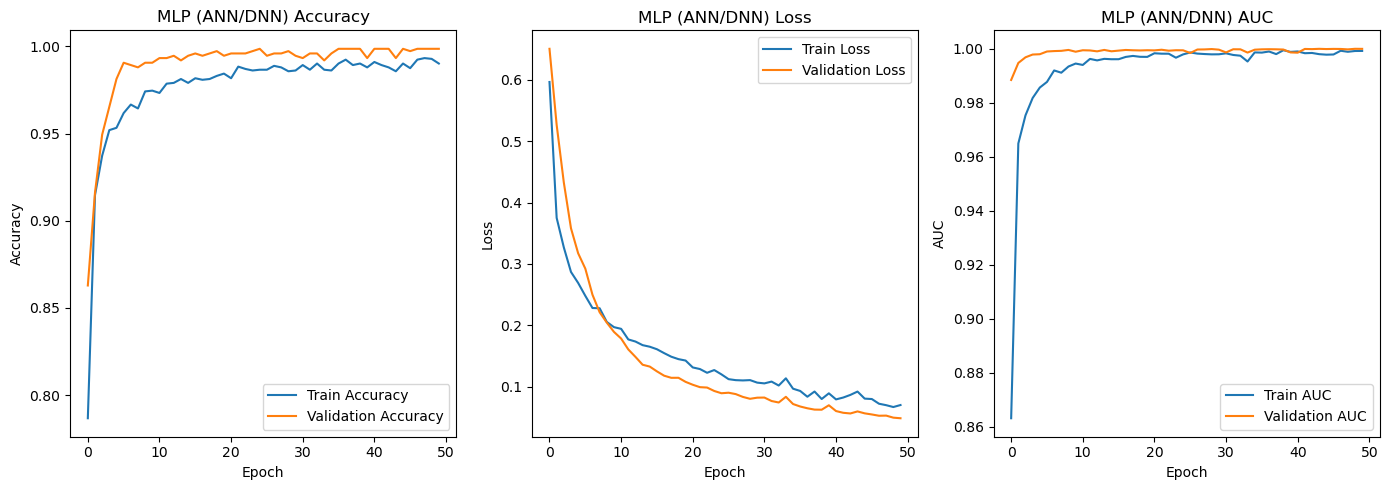

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

MLP (ANN/DNN) Test Set Performance:
Accuracy: 0.9973
Precision: 0.9947
Recall: 1.0000
F1-score: 0.9973
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      1.00       376
     Class 1       0.99      1.00      1.00       375

    accuracy                           1.00       751
   macro avg       1.00      1.00      1.00       751
weighted avg       1.00      1.00      1.00       751


Confusion Matrix:


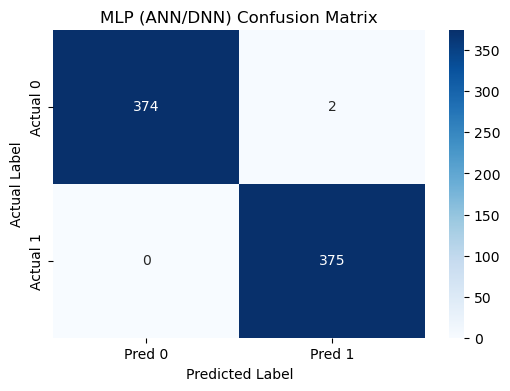

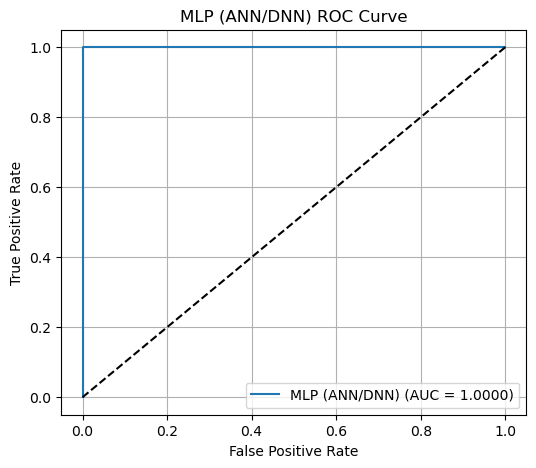

In [13]:
print("\nDiagnostics for MLP evaluation:")
print(f"y_test unique values: {np.unique(y_test, return_counts=True)}")
mlp_results = evaluate_model_performance(mlp_model, X_test_scaled, y_test, history_mlp, "MLP (ANN/DNN)")

## Evaluate LSTM Model


Diagnostics for LSTM evaluation:
y_test unique values: (array([0, 1], dtype=int64), array([376, 375], dtype=int64))

--- Evaluating LSTM (RNN/DNN) Model ---


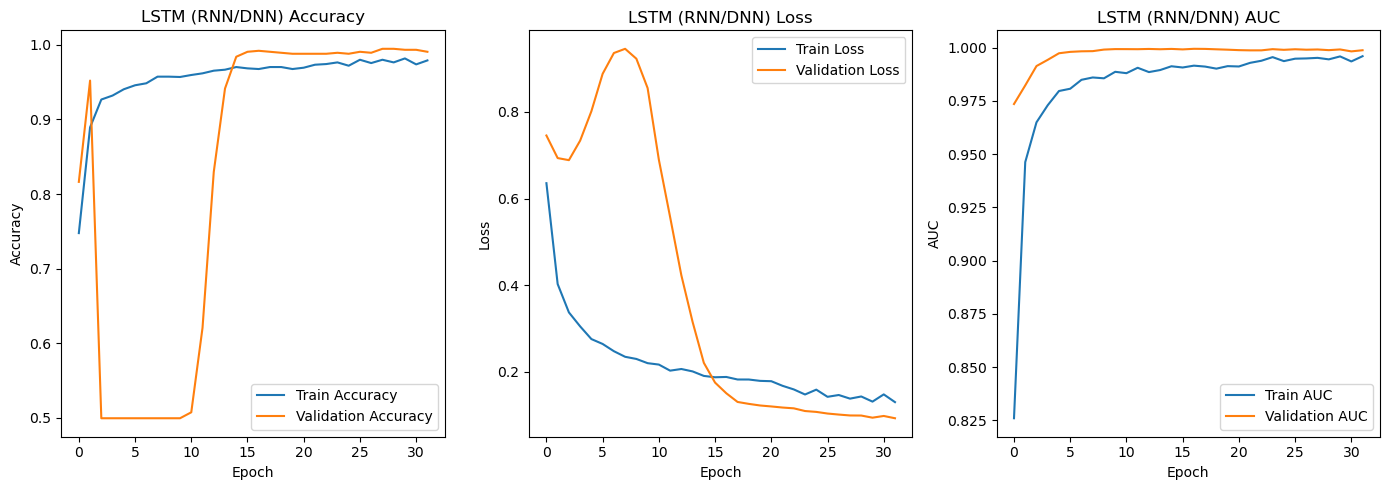

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

LSTM (RNN/DNN) Test Set Performance:
Accuracy: 0.9920
Precision: 0.9843
Recall: 1.0000
F1-score: 0.9921
AUC-ROC: 0.9991

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.98      0.99       376
     Class 1       0.98      1.00      0.99       375

    accuracy                           0.99       751
   macro avg       0.99      0.99      0.99       751
weighted avg       0.99      0.99      0.99       751


Confusion Matrix:


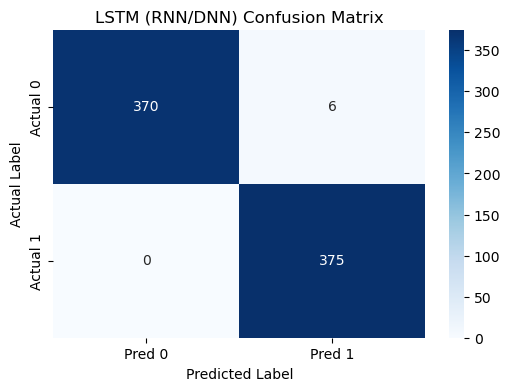

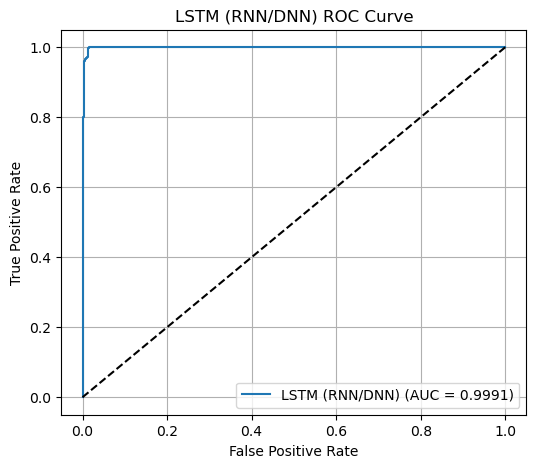

In [14]:
print("\nDiagnostics for LSTM evaluation:")
print(f"y_test unique values: {np.unique(y_test, return_counts=True)}")
lstm_results = evaluate_model_performance(lstm_model, X_test_rnn, y_test, history_lstm, "LSTM (RNN/DNN)")

## Quality Requirements and Results Summary 

In [15]:
print("\n--- Summary of Model Performance on Test Set ---")
results_df = pd.DataFrame([mlp_results, lstm_results])
print(results_df)

print("\nDiscussion of Quality Requirements Met:")
for index, row in results_df.iterrows():
    print(f"\nFor {row['Model']}:")
    print(f"  Accuracy ({row['Accuracy']:.4f})")
    print(f"  Precision ({row['Precision']:.4f})")
    print(f"  Recall ({row['Recall']:.4f})")
    print(f"  F1-Score ({row['F1']:.4f})")
    
    # Correct way to handle conditional display for AUC
    auc_value = row['AUC']
    # Assuming auc_numeric_for_df was set to 0.0 in evaluate_model_performance if calculation failed.
    # A more distinct sentinel like -1.0 or np.nan would be even better if you modify evaluate_model_performance.
    if auc_value == 0.0 and not np.isclose(auc_value, 0.0, atol=1e-5): # Check if it's truly zero due to incalculability
                                                                     # or if the model genuinely got an AUC of 0 (very bad but possible)
                                                                     # A more robust way: have evaluate_model_performance return a specific flag or np.nan
        auc_display = "N/A (or 0.0 if only one class in y_test / calc failed)"
    else:
        auc_display = f"{auc_value:.4f}"
    print(f"  AUC ({auc_display})")


print("\nFurther Considerations:")
print("- Target variable was SIMULATED and BALANCED. Real-world data may differ.")
print("- LSTM used timesteps=1. True sequential data would better test it.")
print("- Hyperparameter tuning is crucial.")
print("- Visual analytics dashboard is next.")


--- Summary of Model Performance on Test Set ---
            Model  Accuracy  Precision  Recall        F1       AUC
0   MLP (ANN/DNN)  0.997337   0.994695     1.0  0.997340  1.000000
1  LSTM (RNN/DNN)  0.992011   0.984252     1.0  0.992063  0.999099

Discussion of Quality Requirements Met:

For MLP (ANN/DNN):
  Accuracy (0.9973)
  Precision (0.9947)
  Recall (1.0000)
  F1-Score (0.9973)
  AUC (1.0000)

For LSTM (RNN/DNN):
  Accuracy (0.9920)
  Precision (0.9843)
  Recall (1.0000)
  F1-Score (0.9921)
  AUC (0.9991)

Further Considerations:
- Target variable was SIMULATED and BALANCED. Real-world data may differ.
- LSTM used timesteps=1. True sequential data would better test it.
- Hyperparameter tuning is crucial.
- Visual analytics dashboard is next.
